# Preliminaries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2022/data.csv


In [2]:
pip install sklego

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.1/224.1 kB 482.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklego.mixture import BayesianGMMClassifier

In [4]:
df = pd.read_csv("../input/tabular-playground-series-jul-2022/data.csv")
df = df.drop(columns="id")

In [5]:
int_cols = [i for i in df.columns if df[i].dtype == int]
int_cols

['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13']

In [6]:
float_cols = [i for i in df.columns if df[i].dtype == float]
float_cols

['f_00',
 'f_01',
 'f_02',
 'f_03',
 'f_04',
 'f_05',
 'f_06',
 'f_14',
 'f_15',
 'f_16',
 'f_17',
 'f_18',
 'f_19',
 'f_20',
 'f_21',
 'f_22',
 'f_23',
 'f_24',
 'f_25',
 'f_26',
 'f_27',
 'f_28']

# Preprocessing

In [7]:
transformer = PowerTransformer()
X_scaled = transformer.fit_transform(df)
X_scaled = pd.DataFrame(X_scaled, columns = df.columns)

# _Optimal Number of Clusters_

In [8]:
def components_number_multiple(max_n, n_seeds):
    bic_scores = []
    for n in range(2,max_n):
        bic_scores_n = []
        for seed in range(n_seeds):
            gmm = GaussianMixture(n_components=n, covariance_type = 'full', n_init=3, random_state=seed)
            gmm.fit(X_scaled)
            bic_scores_n.append(gmm.bic(X_scaled))
        bic_scores.append(bic_scores_n)
    return bic_scores

In [9]:
def plot_components_number_multiple(max_n, n_seeds):
    bic_scores = components_number_multiple(max_n + 1, n_seeds)
    bic_df = pd.DataFrame(data = bic_scores).T
    bic_df.columns = range(2,max_n+1)
    
    f,ax = plt.subplots(figsize=(20,7))
    for i in range(n_seeds):
        sns.lineplot(x=bic_df.columns, y=bic_df.loc[i].values)
    ax.set_xticks(range(2,max_n+1))
    
    return bic_df

In [10]:
# a = plot_components_number_multiple(max_n = 15, n_seeds = 10)

# Feature Importance

In [11]:
bgmm = BayesianGaussianMixture(n_components=7, covariance_type = 'full', n_init=3, random_state=4)
predicted_class = bgmm.fit_predict(X_scaled)
df["class"] = predicted_class

## Visualising Feature Importance

### Continous  features

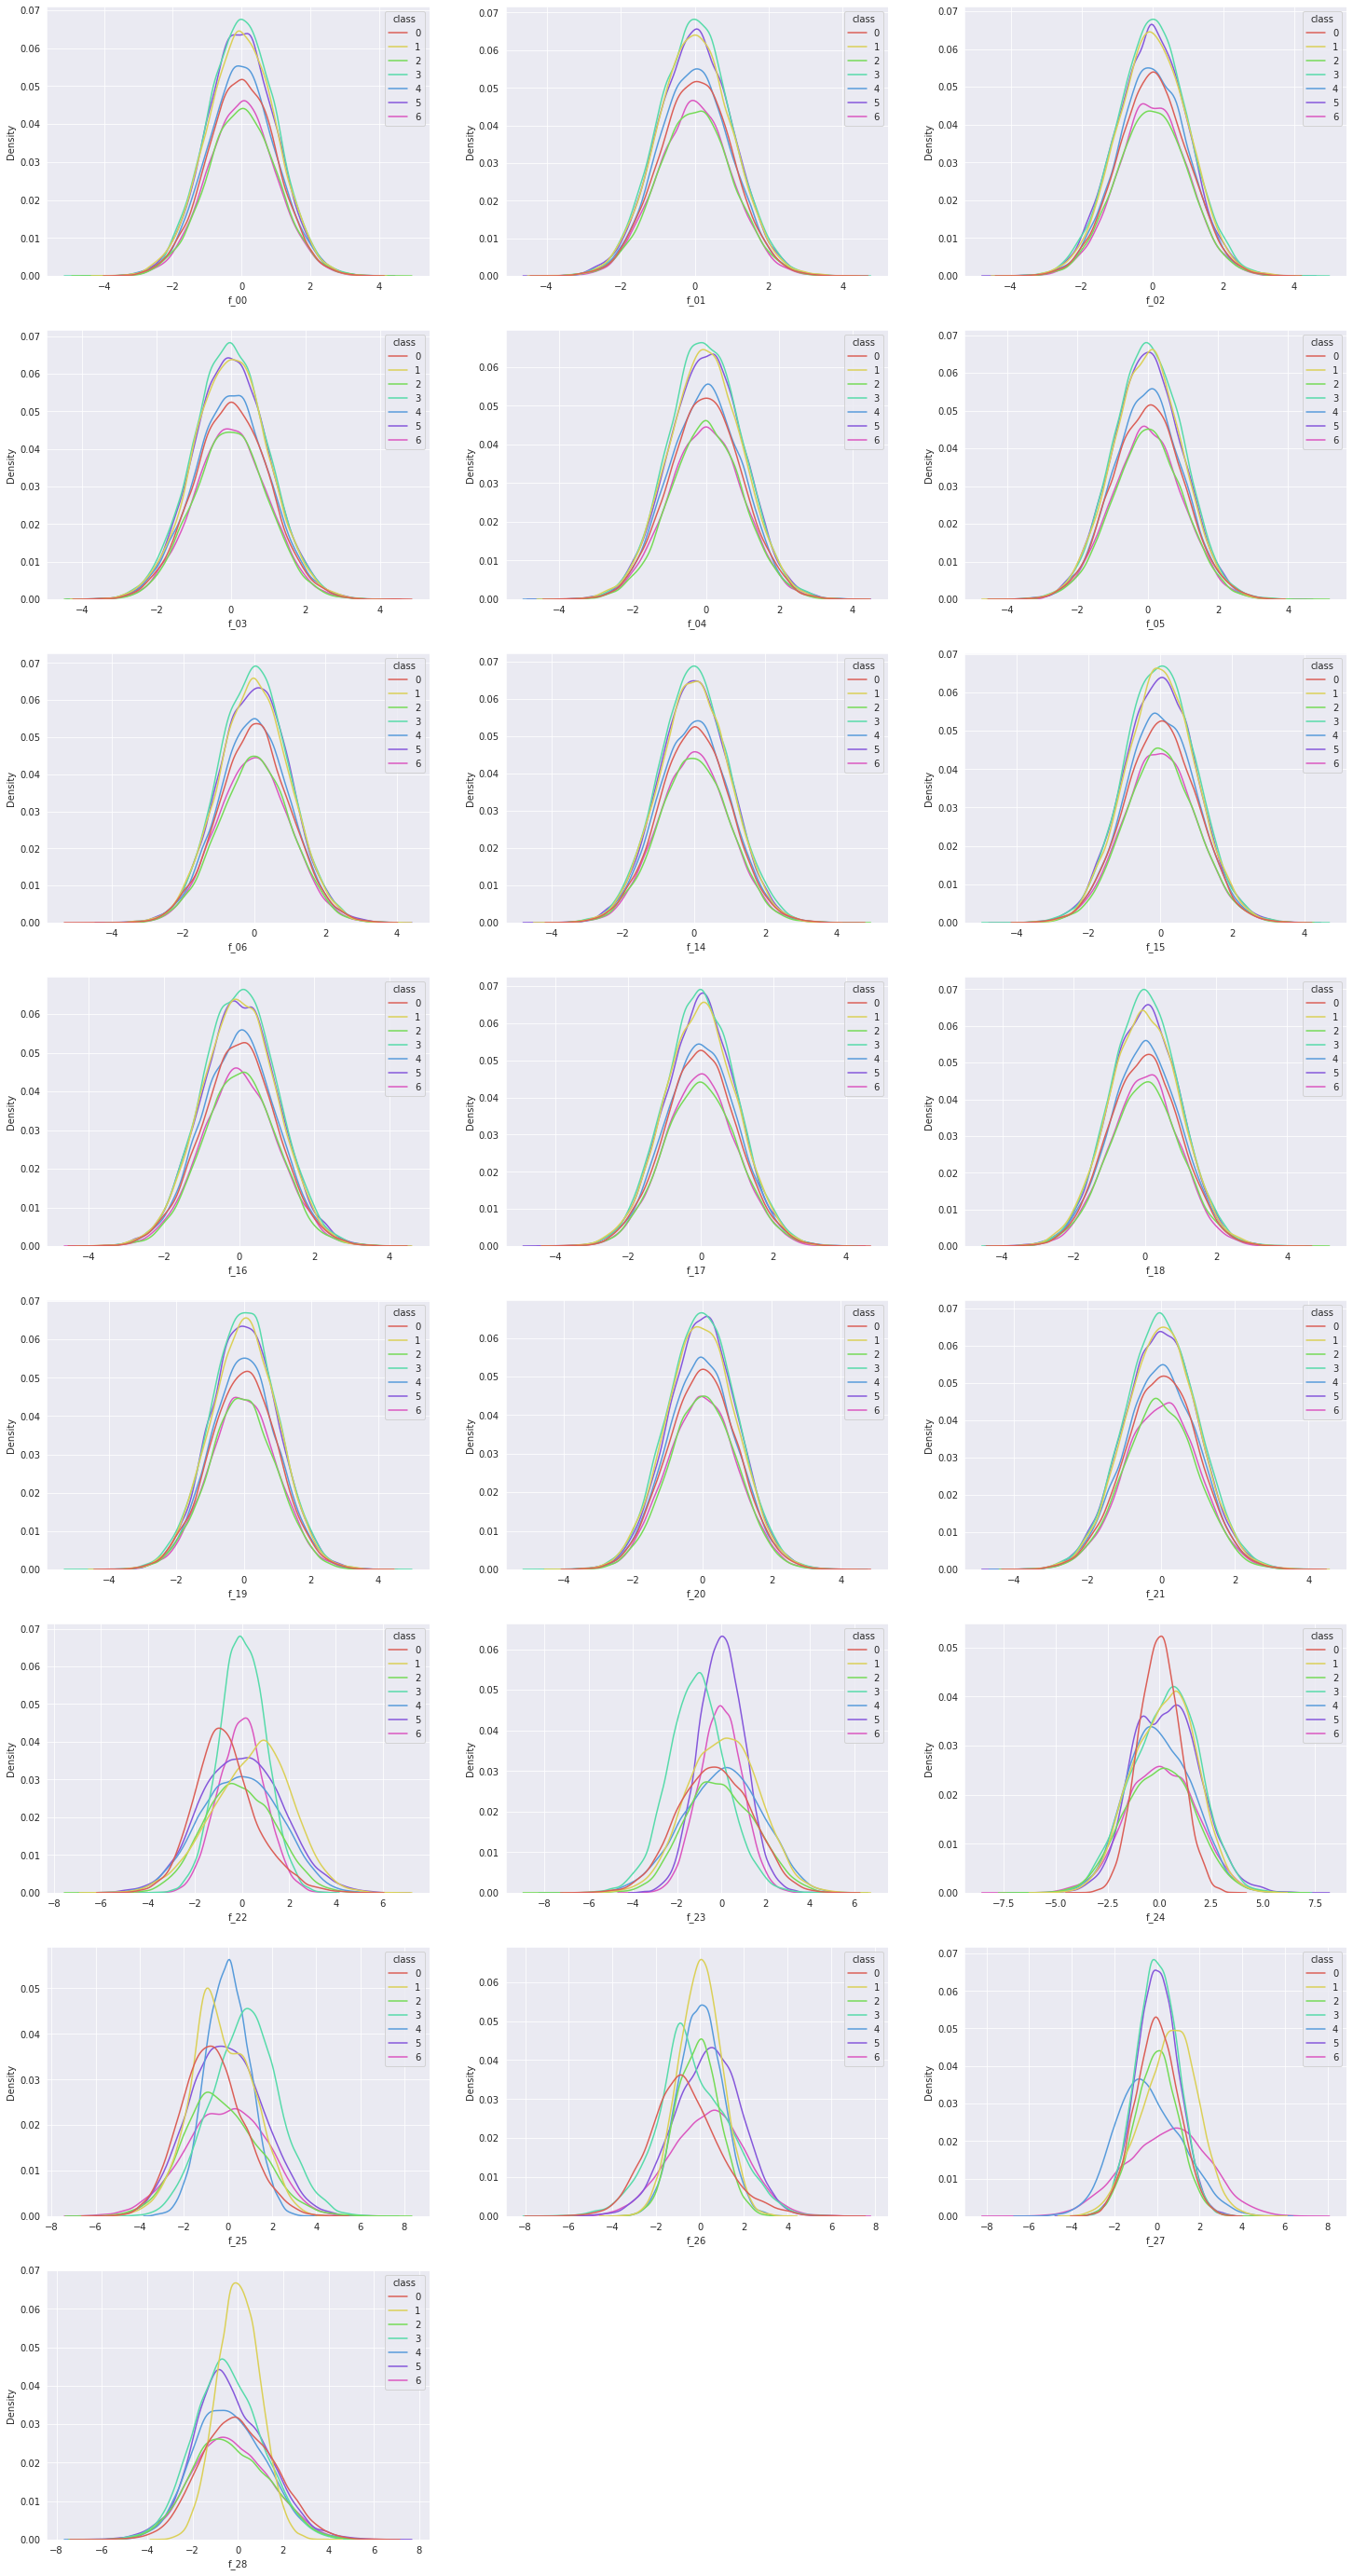

In [12]:
f,ax = plt.subplots(figsize=(25,50))
for n,feature in enumerate(float_cols):
    plt.subplot(8,3,n+1)
    sns.kdeplot(data=df, x=feature, hue="class", palette=sns.color_palette("hls", 7));

### Categorial features

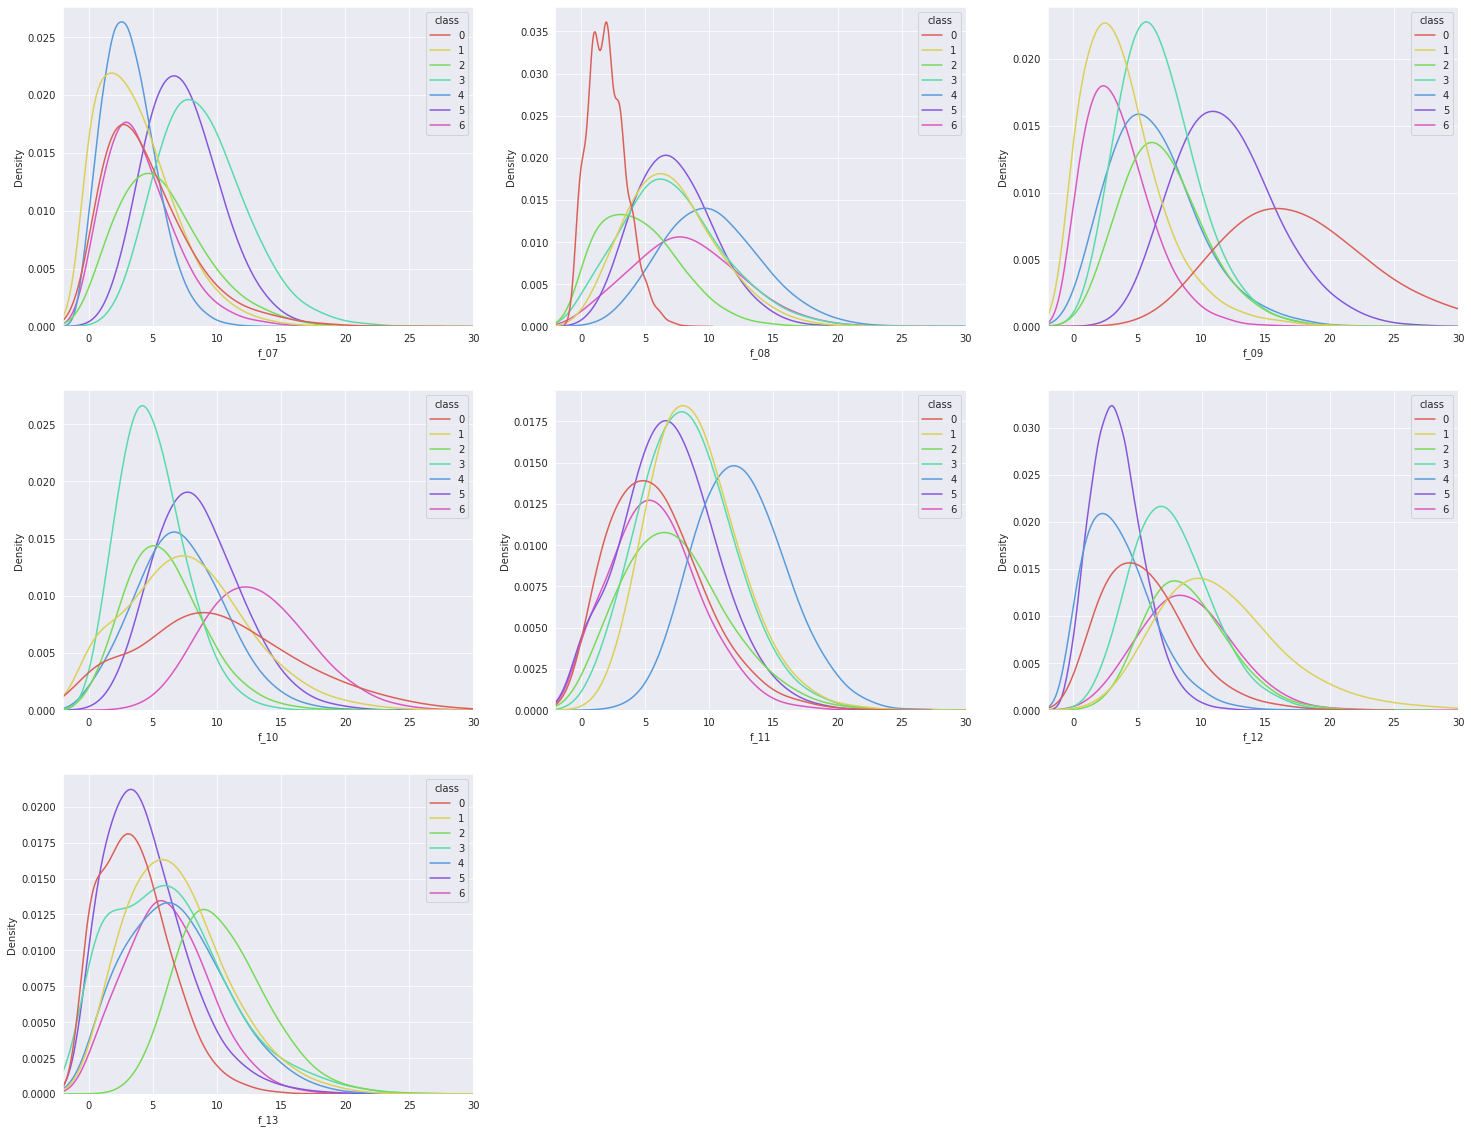

In [13]:
f,ax = plt.subplots(figsize=(25,20))
for n,feature in enumerate(int_cols):
    ax = plt.subplot(3,3,n+1)
    sns.kdeplot(data=df, x=feature, hue="class", bw_adjust=2, palette=sns.color_palette("hls", 7));
    ax.set_xlim([-2,30])

In [14]:
best_cols = ['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13', 'f_22','f_23', 'f_24', 'f_25','f_26','f_27', 'f_28']

In [15]:
def score_clusters(X, predictions, silhouette = True, verbose=False):
    """Evaluate how good our cluster label predictions are"""
    
    db_score = davies_bouldin_score(X=X, labels=predictions)

    ch_score = calinski_harabasz_score(X=X, labels=predictions)
    #the silhouette score is the slowest to compute ~90 secs
    s_score = silhouette_score(X=X, labels=predictions, metric='euclidean')
    
    if verbose:
        print("David Bouldin score: {0:0.4f}".format(db_score))
        print("Calinski Harabasz score: {0:0.3f}".format(ch_score))
        print("Silhouette score: {0:0.4f}".format(s_score))
        
    return db_score, ch_score, s_score

In [16]:
def soft_voting(predict_number, best_cols = best_cols):
    #initialise dataframe with 0's
    predicted_probabilities = pd.DataFrame(np.zeros((len(df),7)), columns=range(1,8))
    # loop with a different random seeds
    for i in range(predict_number):
        print("=========", i, "==========")
        X_scaled_sample = X_scaled.sample(40000)
        gmm = BayesianGaussianMixture(n_components=7, covariance_type = 'full', max_iter=300, init_params="kmeans", n_init=3, random_state=i)
        gmm.fit(X_scaled_sample[best_cols])
        pred_probs = gmm.predict_proba(X_scaled[best_cols])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))
        
        # ensuring clusters are labeled the same value at each fit
        if i == 0:
            initial_centers = gmm.means_
        new_classes = []
        for mean2 in gmm.means_:
            #for the current center of the current gmm, find the distances to every center in the initial gmm
            distances = [np.linalg.norm(mean1-mean2) for mean1 in initial_centers]
            # select the class with the minimum distance
            new_class = np.argmin(distances) + 1 #add 1 as our labels are 1-7 but index is 0-6
            new_classes.append(new_class)
        # if the mapping from old cluster labels to new cluster labels isn't 1 to 1
        if len(new_classes) != len(set(new_classes)):
            print("iteration", i, "could not determine the cluster label mapping, skipping")
            continue
        #apply the mapping by renaming the dataframe columns representing the original labels to the new labels    
        pred_probs = pred_probs.rename(columns=dict(zip(range(1,8),new_classes)))
        
        #add the current prediction probabilities to the overall prediction probabilities
        predicted_probabilities = predicted_probabilities + pred_probs
        # lets score the cluster labels each iteration to see if soft voting is helpful
        score_clusters(X_scaled[best_cols], predicted_probabilities.idxmax(axis=1), verbose=True)
    
    #normalise dataframe so each row sums to 1
    predicted_probabilities = predicted_probabilities.div(predicted_probabilities.sum(axis=1), axis=0)
    return predicted_probabilities

In [17]:
pred_probs = soft_voting(10)

========= 0 ==========
David Bouldin score: 3.6323
Calinski Harabasz score: 3802.591
Silhouette score: 0.0354
========= 1 ==========
David Bouldin score: 3.6280
Calinski Harabasz score: 3801.115
Silhouette score: 0.0353
========= 2 ==========
David Bouldin score: 3.6257
Calinski Harabasz score: 3803.711
Silhouette score: 0.0355
========= 3 ==========
David Bouldin score: 3.6232
Calinski Harabasz score: 3806.527
Silhouette score: 0.0355
========= 4 ==========
David Bouldin score: 3.6199
Calinski Harabasz score: 3805.336
Silhouette score: 0.0355
========= 5 ==========
David Bouldin score: 3.6242
Calinski Harabasz score: 3810.274
Silhouette score: 0.0357
========= 6 ==========
David Bouldin score: 3.6222
Calinski Harabasz score: 3810.508
Silhouette score: 0.0357
========= 7 ==========
David Bouldin score: 3.6241
Calinski Harabasz score: 3810.081
Silhouette score: 0.0357
========= 8 ==========
David Bouldin score: 3.6240
Calinski Harabasz score: 3809.484
Silhouette score: 0.0357
========= 

In [18]:
%%time
score_clusters(X_scaled[best_cols],pred_probs.idxmax(axis=1), verbose=True)

David Bouldin score: 3.6224
Calinski Harabasz score: 3809.291
Silhouette score: 0.0357
CPU times: user 1min 59s, sys: 1min 10s, total: 3min 10s
Wall time: 1min 39s


(3.6224116472608228, 3809.2905612481554, 0.03565022503739866)

In [19]:
def best_class(df):
    new_df = df.copy()
    new_df["highest_prob"] = df.max(axis=1)
    new_df["best_class"] = df.idxmax(axis=1)
    new_df["second_highest_prob"] = df.apply(lambda x: x.nlargest(2).values[-1], axis=1)
    new_df["second_best_class"] = df.apply(lambda x: np.where(x == x.nlargest(2).values[-1])[0][0]+1, axis=1)
    return new_df

In [20]:
cluster_class_probs = best_class(pred_probs)

In [21]:
cluster_class_probs.head()

,1,2,3,4,5,6,7,highest_prob,best_class,second_highest_prob,second_best_class
0,0.000408,0.976126,0.013582,0.003628,0.003569,4.409177e-07,0.002686,0.976126,2,0.013582,3
1,0.002927,0.000336,0.944700,0.000010,0.014862,1.216687e-02,0.024999,0.944700,3,0.024999,7
2,0.001252,0.793430,0.000482,0.204716,0.000101,9.383420e-09,0.000019,0.793430,2,0.204716,4
3,0.026314,0.000017,0.015821,0.088442,0.000050,8.578415e-01,0.011515,0.857841,6,0.088442,4
4,0.976983,0.000005,0.022830,0.000009,0.000169,7.414927e-07,0.000003,0.976983,1,0.022830,3


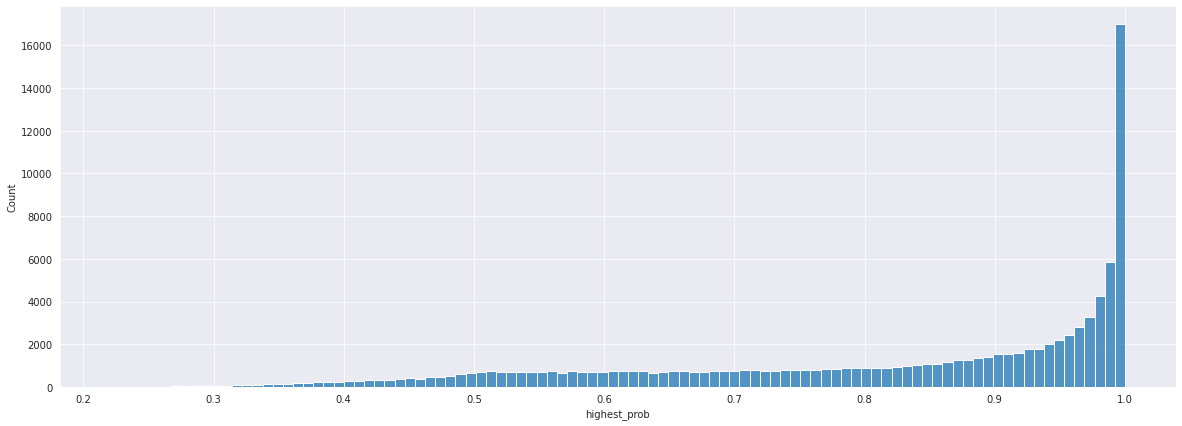

In [22]:
f,ax = plt.subplots(figsize=(20,7))
sns.histplot(cluster_class_probs["highest_prob"], bins=100);

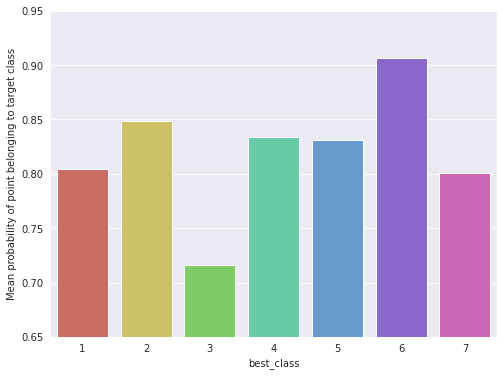

In [23]:
confidence_s = cluster_class_probs.groupby("best_class")["highest_prob"].mean()
f,ax = plt.subplots(figsize=(8,6))
sns.barplot(x=confidence_s.index, y = confidence_s.values, palette=sns.color_palette("hls", 7) );
ax.set_ylabel("Mean probability of point belonging to target class");
ax.set_ylim([0.65,0.95]);

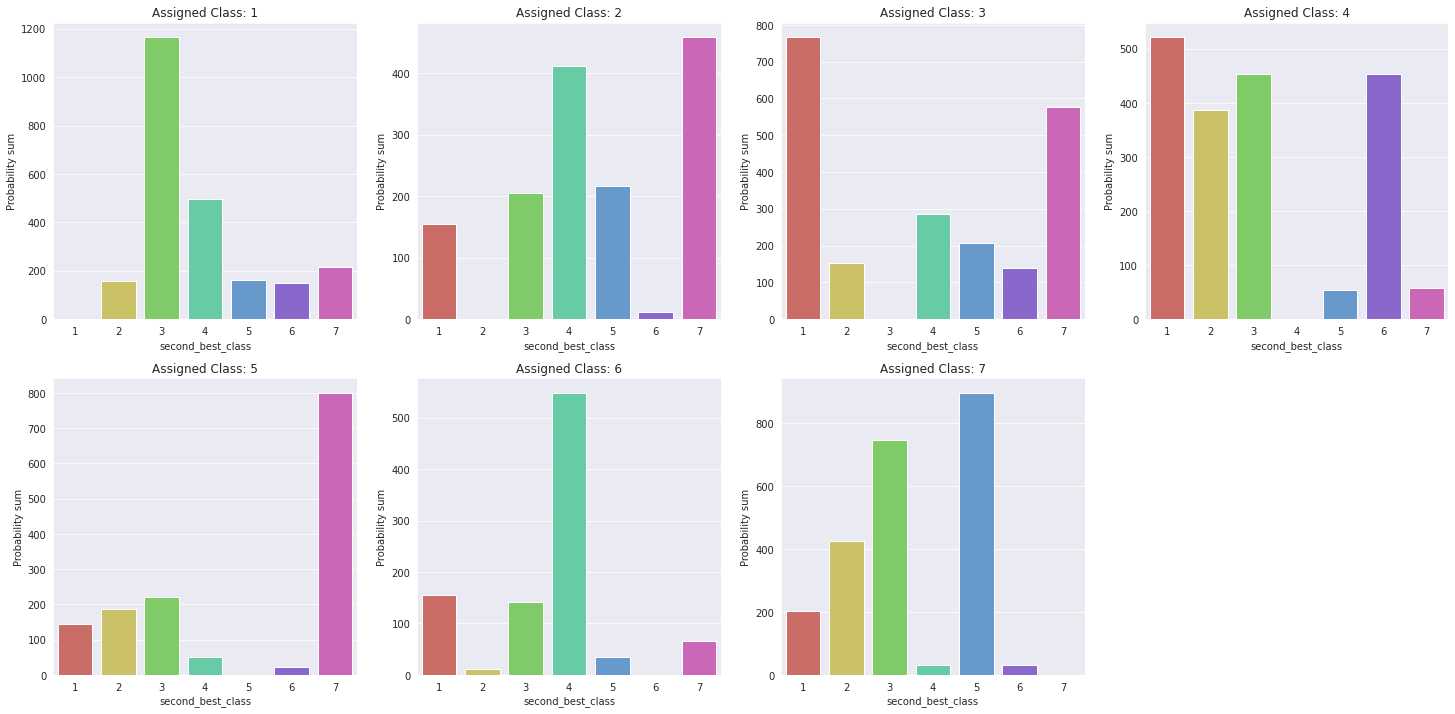

In [24]:
second_highest_probs_sum = cluster_class_probs.groupby(["best_class","second_best_class"])["second_highest_prob"].sum().reset_index()

f,ax = plt.subplots(figsize=(25,12))
format_dataframe = pd.DataFrame({"second_best_class":range(1,8)})
for i in range(1,8):
    second_best_match_for_i = second_highest_probs_sum.loc[second_highest_probs_sum["best_class"] == i, ["second_best_class","second_highest_prob"]]
    #We merge so that all classes 1 to 7 are available, we do this to keep colours consistent throughout plots
    plot_df = pd.merge(left=format_dataframe, right=second_best_match_for_i, how="left", on="second_best_class")
    ax = plt.subplot(2,4,i)
    sns.barplot(data= plot_df, x="second_best_class", y="second_highest_prob",palette=sns.color_palette("hls", 7) );
    ax.set_ylabel("Probability sum")
    ax.set_title("Assigned Class: " + str(i))



In [25]:
confident_predictions = cluster_class_probs.loc[cluster_class_probs["highest_prob"] >= 0.8]
confident_predictions_class = confident_predictions["best_class"]
X_scaled["class"] = confident_predictions_class

In [26]:
train_df = X_scaled.loc[X_scaled["class"] == X_scaled["class"]]
test_df = X_scaled.loc[X_scaled["class"] != X_scaled["class"]]

In [27]:
X = train_df.drop(columns="class").reset_index(drop=True)
y = train_df["class"].reset_index(drop=True)
X_test = test_df.drop(columns="class").reset_index(drop=True)
X_full = X_scaled.drop(columns="class")

### Define models

In [28]:
model_et = ExtraTreesClassifier(n_estimators = 3000,
                                n_jobs = -1,
                                random_state=54
                               )

In [29]:
model_lgbm = LGBMClassifier(objective = 'multiclass',
                            n_estimators = 5000,
                            random_state = 44,
                            learning_rate = 0.05,
                            n_jobs = -1)

In [30]:
model_qda = QuadraticDiscriminantAnalysis()
model_lda = LinearDiscriminantAnalysis()

In [31]:
model_bgmm = BayesianGMMClassifier(
            n_components=7,
            random_state = 1,
            tol =1e-3,
            covariance_type = 'full',
            max_iter = 400,
            n_init=4,
            init_params='kmeans')

In [32]:
models = {"ET":model_et, "LGBM":model_lgbm, "QDA":model_qda, "LDA":model_lda, "BGMM_C":model_bgmm}

### Compare Classificatin performance

In [33]:
def k_fold_cv(model,X,y, verbose=True):
    kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 0)

    feature_imp, y_pred_list, y_true_list, acc_list  = [],[],[],[]
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        if verbose: print("==fold==", fold)
        X_train = X.loc[train_index]
        X_val = X.loc[val_index]

        y_train = y.loc[train_index]
        y_val = y.loc[val_index]

        model.fit(X_train,y_train)

        y_pred = model.predict(X_val)

        y_pred_list = np.append(y_pred_list, y_pred)
        y_true_list = np.append(y_true_list, y_val)

        acc_list.append(accuracy_score(y_pred, y_val))
        if verbose: print('Acc', accuracy_score(y_pred, y_val))

        try:
            feature_imp.append(model.feature_importances_)
        except AttributeError: # if model does not have .feature_importances_ attribute
            pass # returns empty list
            
    return feature_imp, y_pred_list, y_true_list, acc_list, X_val, y_val

In [34]:
def evaluate_models():
    for model_name, model in models.items():
        print("===",model_name,"===")
        feature_imp, y_pred_list, y_true_list, acc_list, X_val, y_val = k_fold_cv(model=model,X=X,y=y, verbose=False)
        acc_score = accuracy_score(y_pred_list, y_true_list)
        print("{0:0.4f}".format(acc_score))

In [35]:
evaluate_models()

=== ET ===
0.9801
=== LGBM ===
0.9956
=== QDA ===
0.9998
=== LDA ===
0.8465
=== BGMM_C ===
0.9873


### Feature importance

In [36]:
feature_imp, y_pred_list, y_true_list, acc_list, X_val, y_val = k_fold_cv(model=model_lgbm,X=X,y=y)

==fold== 0
Acc 0.9954002582311169
==fold== 1
Acc 0.9954002582311169
==fold== 2
Acc 0.9948353776630084
==fold== 3
Acc 0.9958844415752098
==fold== 4
Acc 0.9962876281171819


In [37]:
def fold_feature_importances(model_importances, column_names, model_name, n_folds = 5, ax=None, boxplot=False):
    importances_df = pd.DataFrame({"feature_cols": column_names, "importances_fold_0": model_importances[0]})
    for i in range(1,n_folds):
        importances_df["importances_fold_"+str(i)] = model_importances[i]
    importances_df["importances_fold_median"] = importances_df.drop(columns=["feature_cols"]).median(axis=1)
    importances_df = importances_df.sort_values(by="importances_fold_median", ascending=False)
    if ax == None:
        f, ax = plt.subplots(figsize=(15, 25))
    if boxplot == False:
        ax = sns.barplot(data = importances_df, x = "importances_fold_median", y="feature_cols", color="blue")
        ax.set_xlabel("Median Feature importance across all folds");
    elif boxplot == True:
        importances_df = importances_df.drop(columns="importances_fold_median")
        importances_df = importances_df.set_index("feature_cols").stack().reset_index().rename(columns={0:"feature_importance"})
        ax = sns.boxplot(data = importances_df, y = "feature_cols", x="feature_importance", color="blue", orient="h")
        ax.set_xlabel("Feature importance across all folds");
    plt.title(model_name)
    ax.set_ylabel("Feature Columns")
    return ax

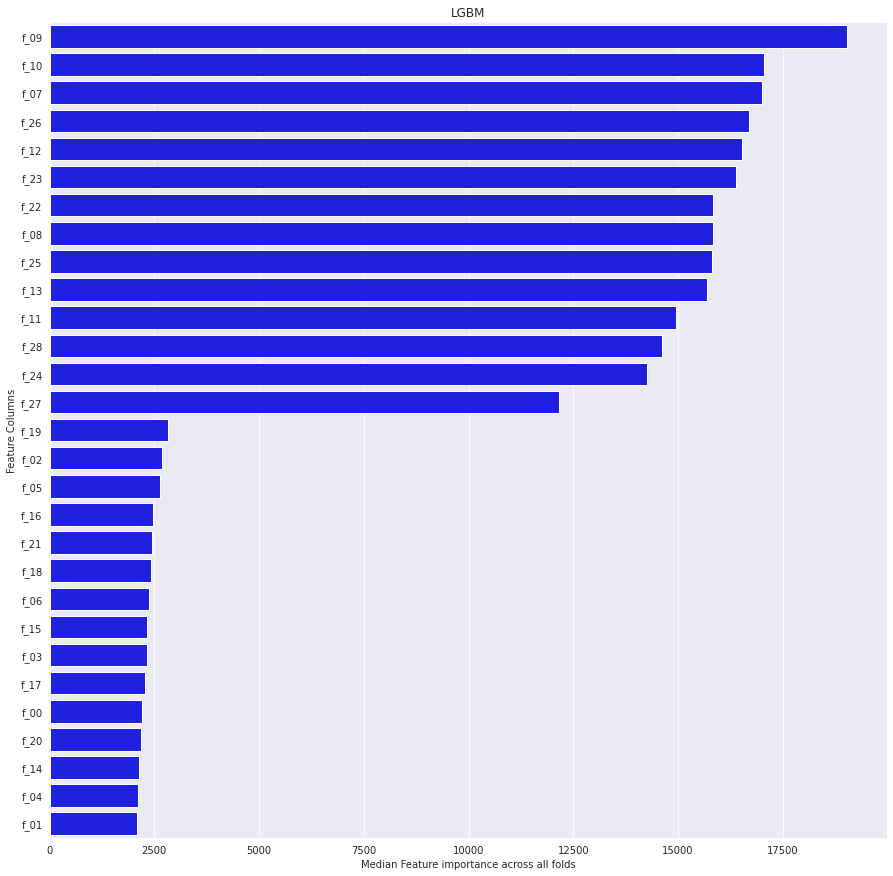

In [38]:
f, ax = plt.subplots(figsize=(15, 15))
fold_feature_importances(model_importances = feature_imp, column_names = X_val.columns, model_name = "LGBM", n_folds = 2, ax=ax, boxplot=False);

## Inference

In [39]:
def fit_predict_all():
    predictions = []
    model_names = []
    scores = []
    for model_name, model in models.items():
        print("===",model_name,"===")
        model.fit(X[best_cols], y)
        preds_prob =  model.predict_proba(X_full[best_cols])
        preds_prob_df = pd.DataFrame(preds_prob, columns=range(1,8), index=X_scaled.index)
        db, ch, s = score_clusters(X_scaled[best_cols], preds_prob_df.idxmax(axis=1), verbose=True)
        scores.append((db,ch,s))
        predictions.append(preds_prob_df)
        model_names.append(model_name)
    
    return predictions, model_names, scores
    

In [ ]:
predictions, model_names, scores = fit_predict_all()

=== ET ===


In [ ]:
cluster_class_probs = cluster_class_probs.loc[:,[1,2,3,4,5,6,7]]

In [ ]:
predictions.append(cluster_class_probs)
model_names.append("BGMM")

In [ ]:
db, ch, s = score_clusters(X_scaled[best_cols], cluster_class_probs.idxmax(axis=1), verbose=True)
scores.append((db,ch,s))

## Combine Predictions

In [ ]:
#chosen fairly randomly
predictions_df = 0.5 * predictions[0] + 1.5 * predictions[1] + 0.5 * predictions[2] + 1.5 * predictions[4] + 0.5 * predictions[5]

#normalise so rows sums to 1
predictions_df = predictions_df.div(predictions_df.sum(axis=1), axis=0)
predictions_df = best_class(predictions_df)

In [ ]:
db, ch, s = score_clusters(X_scaled[best_cols], predictions_df["best_class"], verbose=True)
scores.append((db,ch,s))
model_names.append("combined")

In [ ]:
pd.DataFrame(scores, index=model_names, columns=["Davies-Bouldin Index","Calinski-Harabasz Index","Silhouette Coefficient"])

In [ ]:
f,ax = plt.subplots(figsize=(10,5))
val_c = predictions_df["best_class"].value_counts()
sns.barplot(x=val_c.index, y=val_c.values);

In [ ]:
pca = PCA(random_state = 10)
X_pca = pca.fit_transform(X_scaled[best_cols])
PCA_df = pd.DataFrame({"PCA_1" : X_pca[:,0], "PCA_2" : X_pca[:,1]})   
PCA_df["class"] = predictions_df["best_class"]
    
f,ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data = PCA_df, x = "PCA_1", y = "PCA_2", hue="class", s=2, palette=sns.color_palette("hls", PCA_df["class"].nunique()));

In [ ]:
confidence_s = predictions_df.groupby("best_class")["highest_prob"].mean()
f,ax = plt.subplots(figsize=(8,6))
sns.barplot(x=confidence_s.index, y = confidence_s.values, palette=sns.color_palette("hls", 7) );
ax.set_ylabel("Mean probability of point belonging to target class");
ax.set_ylim([0.4,0.95]);

In [ ]:
second_highest_probs_sum = predictions_df.groupby(["best_class","second_best_class"])["second_highest_prob"].sum().reset_index()

f,ax = plt.subplots(figsize=(25,12))
format_dataframe = pd.DataFrame({"second_best_class":range(1,8)})
for i in range(1,8):
    second_best_match_for_i = second_highest_probs_sum.loc[second_highest_probs_sum["best_class"] == i, ["second_best_class","second_highest_prob"]]
    #We merge so that all classes 1 to 7 are available, we do this to keep colours consistent throughout plots
    plot_df = pd.merge(left=format_dataframe, right=second_best_match_for_i, how="left", on="second_best_class")
    ax = plt.subplot(2,4,i)
    sns.barplot(data= plot_df, x="second_best_class", y="second_highest_prob",palette=sns.color_palette("hls", 7) );
    ax.set_ylabel("Probability sum")
    ax.set_title("Assigned Class: " + str(i))



# Iterative Classification - BGMM Classifier

In [ ]:
def update_predictions(predict_number, y):
    for i in range(predict_number):
        print("=========", i, "==========")
        X_scaled_sample = X_scaled.sample(50000)
        y_sample = y.loc[X_scaled_sample.index]
        
        bgmmC = BayesianGMMClassifier(
        n_components=7,
        random_state = i,
        tol =1e-3,
        covariance_type = 'full',
        max_iter = 300,
        n_init=3,
        init_params='kmeans')
        
        bgmmC.fit(X_scaled_sample[best_cols], y_sample)
        
        pred_probs = bgmmC.predict_proba(X_scaled[best_cols])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))
        
        # lets score the cluster labels each iteration
        score_clusters(X_scaled[best_cols], pred_probs.idxmax(axis=1), verbose=True)
        y = pred_probs.idxmax(axis=1)
        
    return pred_probs

In [ ]:
predicted_probabilities = update_predictions(predict_number=20, y=predictions_df["best_class"])

In [ ]:
predictions_df = best_class(predicted_probabilities)

In [ ]:
second_highest_probs_sum = predictions_df.groupby(["best_class","second_best_class"])["second_highest_prob"].sum().reset_index()

f,ax = plt.subplots(figsize=(25,12))
format_dataframe = pd.DataFrame({"second_best_class":range(1,8)})
for i in range(1,8):
    second_best_match_for_i = second_highest_probs_sum.loc[second_highest_probs_sum["best_class"] == i, ["second_best_class","second_highest_prob"]]
    #We merge so that all classes 1 to 7 are available, we do this to keep colours consistent throughout plots
    plot_df = pd.merge(left=format_dataframe, right=second_best_match_for_i, how="left", on="second_best_class")
    ax = plt.subplot(2,4,i)
    sns.barplot(data= plot_df, x="second_best_class", y="second_highest_prob",palette=sns.color_palette("hls", 7) );
    ax.set_ylabel("Probability sum")
    ax.set_title("Assigned Class: " + str(i))

In [ ]:
f,ax = plt.subplots(figsize=(10,5))
val_c = predictions_df["best_class"].value_counts()
sns.barplot(x=val_c.index, y=val_c.values);

# Submission

In [ ]:
submission = pd.read_csv("../input/tabular-playground-series-jul-2022/sample_submission.csv")

#### submission["Predicted"] = predictions_df["best_class"]
submission.to_csv('submission.csv', index=False)